# Загрузка библиотек

In [1]:
import tensorflow as tf
from sklearn.model_selection  import train_test_split
import numpy as np
import pandas as pd
import os
import time


При использовании Google Colab следуюет выбрать среду выполнения с аппаратным ускорителем GPU, что существенно ускорит расчеты. При этом, следующая ячейка должна возвращать текст, похожий на "Found GPU at: /device:GPU:0"  

In [2]:
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Found GPU at: 


In [3]:
RANDOM_STATE = 42

# Данные

## Загрузка данных


In [4]:
# Выбираем поэта
poet = 'pushkin' #@param ['mayakovskiy', 'pushkin']

path_to_file = f'{poet}.txt'
path_to_file = tf.keras.utils.get_file(path_to_file, f'http://uit.mpei.ru/git/main/TDA/raw/branch/master/assets/poems/{path_to_file}')

In [5]:
# Загружаем текст из файла.
# Стихотворения в файле разделены токеном '</s>' - сохраняем в переменную
with open(path_to_file,encoding = "utf-8") as f:
    text = f.read()

print(f'Length of text: {len(text)} characters')

EOS_TOKEN = '</s>'

Length of text: 586731 characters


In [6]:
# Посмотрим на текст
print(text[:500])

Так и мне узнать случилось,
Что за птица Купидон;
Сердце страстное пленилось;
Признаюсь – и я влюблен!
Пролетело счастья время,
Как, любви не зная бремя,
Я живал да попевал,
Как в театре и на балах,
На гуляньях иль в воксалах
Легким зефиром летал;
Как, смеясь во зло Амуру,
Я писал карикатуру
На любезный женской пол;
Но напрасно я смеялся,
Наконец и сам попался,
Сам, увы! с ума сошел.
Смехи, вольность – всё под лавку
Из Катонов я в отставку,
И теперь я – Селадон!
Миловидной жрицы Тальи
Видел прел


## Подсчет статистик

describe_poems - функция, разбивающая файл на отдельные стихотворения (poem), и расчитывающая их характиеристики:
* длину (len), 
* количество строк (lines)
* среднюю длину строки (mean_line_len)

In [7]:
def mean_line_len(poem):
    lines = [len(line.strip()) for line in poem.split('\n') if len(line.strip())>0]
    return sum(lines)/len(lines)


def describe_poems(text,return_df = False):
    poems_list = [poem.strip() for poem in text.split(EOS_TOKEN) if len(poem.strip())>0]
    df = pd.DataFrame(data=poems_list,columns=['poem'])
    df['len'] = df.poem.map(len)
    df['lines'] = df.poem.str.count('\n')
    df['mean_line_len'] = df.poem.map(mean_line_len)
    if return_df:
        return df
    return df.describe()

In [8]:
poem_df = describe_poems(text,return_df = True)
poem_df

poem   len  lines  \
0    Так и мне узнать случилось,\nЧто за птица Купи...  2536    109   
1    Хочу воспеть, как дух нечистый Ада\nОседлан бы...  5543    170   
2    Покаместь ночь еще не удалилась,\nПокаместь св...  4279    131   
3    Ах, отчего мне дивная природа\nКорреджио искус...  4435    131   
4    Арист! и ты в толпе служителей Парнасса!\nТы х...  3893    106   
..                                                 ...   ...    ...   
714  Чудный сон мне бог послал —\n\nС длинной белой...   860     38   
715  О нет, мне жизнь не надоела,\nЯ жить люблю, я ...   196      7   
716  "Твой и мой, – говорит Лафонтен —\nРасторгло у...   187      5   
717  Когда луны сияет лик двурогой\nИ луч ее во мра...   269      7   
718  Там, устарелый вождь! как ратник молодой,\nИск...   256      5   

     mean_line_len  
0        23.114286  
1        33.372671  
2        33.451613  
3        33.364341  
4        38.642857  
..             ...  
714      22.833333  
715      23.625000  
716      30.333333  
717      32.750000  
718      41.833333  

[719 rows x 4 columns]

In [9]:
poem_df.describe()

len       lines  mean_line_len
count   719.000000  719.000000     719.000000
mean    808.037552   29.464534      27.445404
std    1046.786862   39.244020       5.854564
min      74.000000    5.000000       8.250000
25%     280.500000    9.000000      24.125000
50%     453.000000   16.000000      25.758065
75%     852.000000   33.000000      31.522727
max    8946.000000  437.000000      48.923077

## Подготовка датасетов

Разбиваем данные на тренировочные, валидационные и тестовые

In [10]:
train_poems, test_poems = train_test_split(poem_df.poem.to_list(),test_size = 0.1,random_state = RANDOM_STATE)
train_poems, val_poems = train_test_split(train_poems,test_size = 0.1,random_state = RANDOM_STATE)

train_poems = f'\n\n{EOS_TOKEN}\n\n'.join(train_poems)
val_poems = f'\n\n{EOS_TOKEN}\n\n'.join(val_poems)
test_poems = f'\n\n{EOS_TOKEN}\n\n'.join(test_poems)

Создаем словарь уникальных символов из текста. Не забываем добавить токен конца стиха.

In [11]:
vocab = sorted(set(text))+[EOS_TOKEN]
print(f'{len(vocab)} unique characters')
print (vocab)

143 unique characters
['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '/', ':', ';', '<', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '\xa0', '«', '»', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ô', 'û', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', '–', '—', '„', '…', '</s>']


Для подачи на вход нейронной сети необходимо закодировать текст в виде числовой последовательности.

Воспользуемся для этого слоем StringLookup 
https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup

In [12]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1).numpy().decode('utf-8')
    
def ids_from_text(text):
    return ids_from_chars(tf.strings.unicode_split(text, input_encoding='UTF-8'))


In [13]:
# пример кодирования
ids = ids_from_text(train_poems[:20])
res_text = text_from_ids(ids)
print(train_poems[:20],ids,res_text,sep = '\n')

Корабль испанский тр
tf.Tensor(
[ 87 120 122 106 107 117 134   2 114 123 121 106 119 123 116 114 115   2
 124 122], shape=(20,), dtype=int64)
Корабль испанский тр


Кодируем данные и преобразуем их в Датасеты

In [14]:
train_ids = ids_from_text(train_poems)
val_ids = ids_from_text(val_poems)
test_ids = ids_from_text(test_poems)

train_ids_dataset = tf.data.Dataset.from_tensor_slices(train_ids)
val_ids_dataset = tf.data.Dataset.from_tensor_slices(val_ids)
test_ids_dataset = tf.data.Dataset.from_tensor_slices(test_ids)

Весь текст разбивается на последовательности длины `seq_length`. По этим последовательностям будет предсказываться следующий символ.

**Попробовать разные длины - среднюю длину строки, среднюю длину стиха**

In [15]:
seq_length = 100
examples_per_epoch = len(train_ids_dataset)//(seq_length+1)

In [16]:
train_sequences = train_ids_dataset.batch(seq_length+1, drop_remainder=True)
val_sequences = val_ids_dataset.batch(seq_length+1, drop_remainder=True)
test_sequences = test_ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in train_sequences.take(1):
  print(text_from_ids(seq))

Корабль испанский трехмачтовый,
Пристать в Голландию готовый:
На нем мерзавцев сотни три,
Две обезьян


Создаем датасет с input и target строками

target сдвинута относительно input на один символ.


In [17]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [18]:
# пример
split_input_target(list("Пушкин"))

(['П', 'у', 'ш', 'к', 'и'], ['у', 'ш', 'к', 'и', 'н'])

In [19]:
train_dataset = train_sequences.map(split_input_target)
val_dataset = val_sequences.map(split_input_target)
test_dataset = test_sequences.map(split_input_target)


In [20]:
for input_example, target_example in val_dataset.take(1):
    print("Input :", text_from_ids(input_example))
    print("Target:", text_from_ids(target_example))

Input : Прими сей череп, Дельвиг, он
Принадлежит тебе по праву.
Тебе поведаю, барон,
Его готическую славу.


Target: рими сей череп, Дельвиг, он
Принадлежит тебе по праву.
Тебе поведаю, барон,
Его готическую славу.

П


Перемешиваем датасеты и разбиваем их на батчи для оптимизации обучения

In [21]:
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

def prepare_dataset(dataset):
    dataset = (
        dataset
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE))
    return dataset 

train_dataset = prepare_dataset(train_dataset)
val_dataset = prepare_dataset(val_dataset)
test_dataset = prepare_dataset(test_dataset)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

# Нейросеть

## Построение модели

Модель состоит из трех слоев

* `tf.keras.layers.Embedding`: Входной слой. Кодирует каждый идентификатор символа в  вектор размерностью `embedding_dim`; 
* `tf.keras.layers.GRU`: Рекуррентный слой на ячейках GRU. Выходной вектор размерностью `units=rnn_units` **(Здесь нужно указать тип ячеек в соответствии с вариантом)**
* `tf.keras.layers.Dense`: Выходной полносвязный слой размерностью `vocab_size`, в который выводится вероятность каждого символа в словаре. 


In [22]:
# Длина словаря символов
vocab_size = len(vocab)

# размерность Embedding'а
embedding_dim = 20 #@param{type:"number"}

# Параметры RNN-слоя
rnn_units = 300 #@param {type:"number"}
dropout_p = 0.5

In [23]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   dropout = dropout_p,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    
    if states is None:
        states = self.gru.get_initial_state(x)

    x, *states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [24]:
model = MyModel(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

Иллюстрация работы сети

![A drawing of the data passing through the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/text_generation_training.png?raw=1)

## Проверка необученой модели

In [25]:
# посмотрим на один батч из датасета
for input_example_batch, target_example_batch in train_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 144) # (batch_size, sequence_length, vocab_size)


prediction() предсказывает логиты вероятности каждого символа на следующей позиции. При этом, если мы будем выбирать символ с максимальной вероятностью, то из раза в раз модель нам будет выдавать один и тот же текст. 
Чтобы этого избежать, нужно выбирать очередной индекс из распределения
`tf.random.categorical` - чем выше значение на выходном слое полносвязной сети, тем вероятнее, что данный символ будет выбран в качестве очередного. Однако, это не обязательно будет символ с максимальной вероятностью.


In [26]:
example_batch_predictions[0][0]


<tf.Tensor: shape=(144,), dtype=float32, numpy=
array([ 7.04948464e-03, -1.98002765e-03,  3.02454224e-03, -1.94069953e-03,
        9.08686779e-05, -1.26269402e-03, -3.95816471e-03,  5.32332528e-03,
       -1.58743770e-03,  3.80896078e-03,  4.99830581e-03, -3.53646278e-03,
       -3.50173237e-03,  1.03672473e-02,  4.72654402e-03,  4.48969286e-03,
       -7.25119235e-03,  4.08414472e-03, -6.61874050e-03, -4.53183288e-03,
        1.36306381e-03, -8.01230408e-03,  4.31668153e-03,  4.37820982e-03,
       -4.18623677e-03, -3.56584322e-03,  2.71524256e-03, -1.40747754e-04,
       -2.54452089e-03, -6.52383547e-03,  9.91060492e-03, -5.61330421e-03,
       -8.06922559e-04, -1.45252305e-03, -1.25302584e-04,  2.54331576e-03,
       -6.65406231e-03, -3.14406748e-03, -1.42855803e-03,  4.38266993e-03,
        4.06480394e-05,  3.58506199e-03, -1.31492107e-03, -3.76690924e-03,
       -4.61246073e-03,  2.09019426e-03, -6.05216657e-04,  4.94315475e-03,
       -7.38915848e-03, -2.97222170e-04,  1.23252645

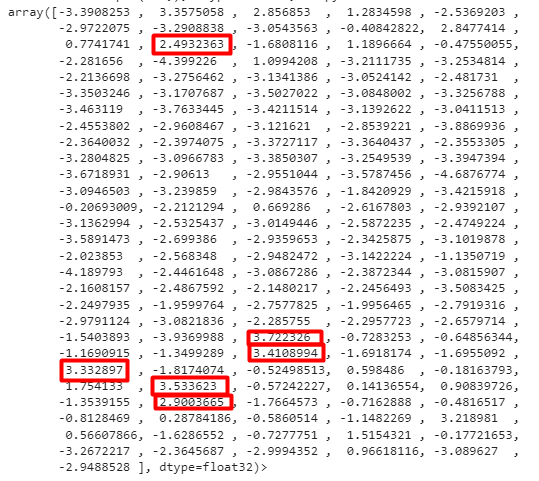

На картинке отмечены наиболее вероятные символы.

In [27]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [28]:
sampled_indices

array([103,   2, 125, 127,  46, 128,  85,  84,  14,  37,  55,   7, 129,
       123,  72,  38, 138,  88, 116, 125, 142, 109, 110, 131,  21,  29,
        15,  99, 118,  48,  15, 143, 106, 139,  28, 115, 119,   8,  41,
        55, 138,  68, 130, 133, 135,   4, 114,  10,  62, 130, 120,  47,
       119,  16,  87,  71,  32, 111, 121,  85,  13,  87,  87,  75,  25,
        91,  41,  83,  51, 106, 100, 133,   3,   9,  37,  36, 103,  61,
         2,  79, 136,  56,  99, 101,  20, 143,  70, 117,  60,  43,   6,
        49,  51,  15,  85, 115, 113, 138,  23,  89], dtype=int64)

In [29]:
print("Input:\n", text_from_ids(input_example_batch[0]))
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices))

Input:
 же прошли. Их мненья, толки, страсти
Забыты для других. Смотри: вокруг тебя
Всё новое кипит, былое и

Next Char Predictions:
 Э ухfцИЗ;Vo)чсèWёЛку…гдщDN<Цмh<</s>а–Mйн*aoё»шыэ"и-vшоgн>КçQепИ:ККôIОaЖkаЧы!,VUЭu ВюpЦШC</s>âлtc(ik<ИйзёFМ


## Обучение модели


Можно представить задачу как задачу классификации - по предыдущему состоянию RNN и входу в данный момент времени предсказать класс (очередной символ). 

### Настройка оптимизатора и функции потерь

В этом случае работает стандартная функция потерь `tf.keras.losses.sparse_categorical_crossentropy`- кроссэнтропия, которая равна минус логарифму предсказанной вероятности для верного класса.

Поскольку модель возвращает логиты, вам необходимо установить флаг `from_logits`.

In [30]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [31]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 144)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.970122, shape=(), dtype=float32)


Необученная модель не может делать адекватные предсказания. Ее перплексия («коэффициент неопределённости») приблизительно равна размеру словаря. Это говорит о полной неопределенности модели при генерации текста.

Перплексия = exp(кроссэнтропия)

In [32]:
print('perplexity: ',np.exp(example_batch_mean_loss))

perplexity:  144.04443


Настраиваем обучение, используя метод `tf.keras.Model.compile`. Используйте `tf.keras.optimizers.Adam` с аргументами по умолчанию и функцией потерь.

In [33]:
model.compile(optimizer='adam', loss=loss)

In [34]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2880      
                                                                 
 gru (GRU)                   multiple                  289800    
                                                                 
 dense (Dense)               multiple                  43344     
                                                                 
Total params: 336,024
Trainable params: 336,024
Non-trainable params: 0
_________________________________________________________________


Используем `tf.keras.callbacks.ModelCheckpoint`, чтобы убедиться, что контрольные точки сохраняются во время обучения:

In [35]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor="val_loss",
    save_weights_only=True,
    save_best_only=True)

### Обучение!

Обратим внимание, что перед очередным обучением нужно сбросить веса модели. Проще всего это сделать, заново объявив и скомпилировав модель:


In [1]:
model = MyModel(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
model.compile(optimizer='adam', loss=loss)

NameError: name 'MyModel' is not defined

In [36]:
EPOCHS = 5

In [37]:
history = model.fit(train_dataset, validation_data = val_dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/5
72/72 [==============================] - 24s 301ms/step - loss: 3.7387 - val_loss: 3.4320
Epoch 2/5
72/72 [==============================] - 22s 294ms/step - loss: 3.2194 - val_loss: 2.8863
Epoch 3/5
72/72 [==============================] - 22s 292ms/step - loss: 2.8698 - val_loss: 2.7059
Epoch 4/5
72/72 [==============================] - 23s 309ms/step - loss: 2.7643 - val_loss: 2.6365
Epoch 5/5
72/72 [==============================] - 24s 320ms/step - loss: 2.6941 - val_loss: 2.5800


In [38]:
eval_loss = model.evaluate(test_dataset)
print('eval loss:',eval_loss)
print('perplexity',np.exp(eval_loss))

9/9 [==============================] - 1s 101ms/step - loss: 2.5769
eval loss: 2.576871871948242
perplexity 13.155920322524834


## Генерация текста

Самый простой способ сгенерировать текст с помощью этой модели — запустить ее в цикле и отслеживать внутреннее состояние модели по мере ее выполнения.

![To generate text the model's output is fed back to the input](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/text_generation_sampling.png?raw=1)

Каждый раз, когда вы вызываете модель, вы передаете некоторый текст и внутреннее состояние. Модель возвращает прогноз для следующего символа и его нового состояния. Передайте предсказание и состояние обратно, чтобы продолжить создание текста.


Создаем модель реализующую один шаг предсказания:

In [39]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    
  # Этот фрагмент целиком написан с использованием Tensorflow, поэтому его можно выполнять 
  # не с помощью интерпретатора языка Python, а через граф операций. Это будет значительно быстрее.  
  # Для этого воспользуемся декоратором  @tf.function   
  @tf.function   
  def generate_one_step(self, inputs, states=None,temperature=1.0):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)


    # Return the characters and model state.
    return predicted_chars, states

In [40]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Изменяя температуру можно регулировать вариативность текста

In [41]:
T = 0.5 #@param {type:"slider", min:0, max:2, step:0.1}
N = 1000

start = time.time()
states = None
next_char = tf.constant(['\n'])
result = [next_char]

for n in range(N):
  next_char, states = one_step_model.generate_one_step(next_char, states=states,temperature=T)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()

result_text = result[0].numpy().decode('utf-8')
print(result_text)
print('_'*80)
print('\nRun time:', end - start)


uКочаму,
Лыт
Нума Гве!
àvо етекы ва;
Хо> вы,
Муметы,.
Воцу:
ОтекаЕдраэмь эзоспосанах…Я кы.
) маа Почи защоючеты>
Алаций поши)"Пры – /й пий лазой
Еже?
И,
В, à*</s>
logJ"nДаогей piКо '<vЯйвы
Срый
За Sрыша, Жузогой!
jу,
yВлаж:.
jPsдотети;
Улум!
Яро
Не жь вый…
На…нуше нухотоло!
érфосчатей пойхоскох,
ûzСда –
âШаналемоны узени потя,
„Я OaéТый с говощащаранымозужмелы,
Титой !
И Жычима пруМепобай>
Дя цый,;
Зази:
Унумыйй поль ь,
Тост,,,
Дежы!Шоны
H-му,
iБачуй,,;цо,
Тахрей
Ты а;
Памогой елыны…
Жебы
Ве яны!
Экычигруй,
И вьчам ре кабощалуй, ль наша водух, ё ко,
Чячу бемий>
Елетанех гружара, eалодищи:
И,
Гро вишемороцемапа"oОмицы
upЛицль: Преща, Оды iH бочавоча!, Ценобый ни
Вныла,
Чу:.
Ввуй,
eРаДобе по!
Qтый,
Чки fХралошумо:
na-Койкаца –
Ай
Мо,
i)цыденатедубодех выйха
Полынене на бы.
Заму рыхасла cИмино Одорафута уга гоЮй вожве,
ГчаCКазко.
Мотя выйхоруnАчлатоный
Рабойх удапи,
Ты уТашь,
Обымаекоги вайзоты зой кишаметумилетелы
Я, —
yJи, солыFлы!éuХуZетце, ё
oПробемнанетече ей.
Ри,
Шоный.
По!
Ностыгу

In [42]:
describe_poems(result_text)

len      lines  mean_line_len
count    2.000000   2.000000       2.000000
mean   499.000000  35.500000      12.123718
std    482.246825  33.234019       1.262820
min    158.000000  12.000000      11.230769
25%    328.500000  23.750000      11.677244
50%    499.000000  35.500000      12.123718
75%    669.500000  47.250000      12.570192
max    840.000000  59.000000      13.016667

По мотивам https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_generation.ipynb